In [1]:
from neuprint import Client
from neuprint import NeuronCriteria as NC
from neuprint import fetch_neurons
from neuprint import fetch_adjacencies
from neuprint.utils import connection_table_to_matrix
import bokeh.palettes
from bokeh.plotting import figure, show, output_notebook
output_notebook()
import hvplot.pandas
import holoviews as hv
import numpy as np
import pandas as pd
import ants
import nibabel as nib
import os
import pickle
import scipy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import networkx as nx
from fa2 import ForceAtlas2
from nxviz import CircosPlot
import nxviz as nv
import tqdm
import time
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import bigbadbrain as bbb
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.colors as mcolors
import brainsss

Loading BokehJS ...

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
### Load Luke Mean ###
luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)
luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)

### Load JFRC2018 ###
fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
#fixed_lowres = ants.resample_image(fixed,(2,2,2),use_voxels=False)
fixed_lowres = ants.resample_image(fixed,(2.6,2.6,5),use_voxels=False)

### Load Atlas ###
# atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/jfrc_2018_rois_improve_reorient_transformed.nii"
# atlas = np.asarray(nib.load(atlas_path).get_data().squeeze(), dtype='float32')
# atlas = ants.from_numpy(atlas)
# atlas.set_spacing((.76,.76,.76))
# atlas = ants.resample_image(atlas,(2,2,2),use_voxels=False)

In [3]:
### Load supervoxel labels ###
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file)

In [4]:
###########################
### Create Notch Filter ###
###########################

fs = 50.0  # Sample frequency (Hz)
f0 = 1.8797  # Frequency to be removed from signal (Hz)
Q = 0.2  # Quality factor <---- IMPORTANT
w0 = f0/(fs/2)  # Normalized Frequency

# Design notch filter
b_notch, a_notch = signal.iirnotch(w0, Q)

# Frequency response
w, h = signal.freqz(b_notch, a_notch)

# Generate frequency axis
freq = w*fs/(2*np.pi)

# ##########################
# ### Apply notch filter ###
# ##########################

# outputSignal = signal.filtfilt(b_notch, a_notch, signal_corrupt)

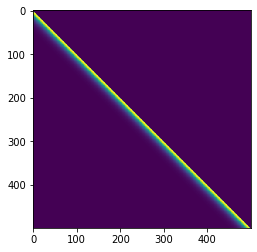

In [5]:
###########################################
### Create estimate of gcamp6f kinetics ###
###########################################

def fit_eq(x, a, b, c, d, e):
    return a*(1-np.exp(-x/b))*(c*np.exp(-x/d)) + e

x = np.arange(0, 50, 1)
y = fit_eq(x, 1, 4, -1, 8, 0)

filter_ = y*-1
filter_padded = np.pad(filter_, (0, 450), 'constant')

toe = scipy.linalg.toeplitz(filter_padded,r=[0]*500)
plt.imshow(toe)

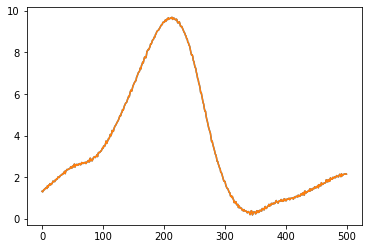

In [14]:
#main_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210316_neural_weighted_behavior/"
main_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220921_neural_weighted_behavior/"

response_files = [os.path.join(main_path, file) for file in os.listdir(main_path) if 'responses' in file]
bbb.sort_nicely(response_files)

responses = []
for file in response_files:
    responses.append(np.load(file))
responses = np.asarray(responses)

responses_split = np.reshape(responses, (49-18,2000,4,500))
responses_notch = signal.filtfilt(b_notch, a_notch, responses_split, axis=-1)

cluster_id = np.argmax(np.sum(responses_notch[20,:,0,:].real, axis=1))
plt.plot(responses_notch[20,cluster_id,0,:])
plt.plot(new)

In [16]:
file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220921_neural_weighted_behavior/master_X_clipped.npy"
X = np.load(file)

In [17]:
X.shape

(49, 9, 2000, 3384)

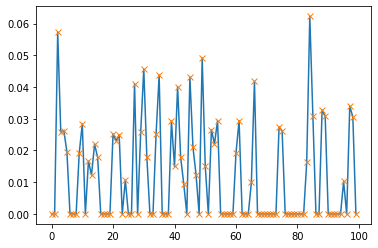

In [24]:
plt.plot(X[0,0,250,2000:2100])
plt.plot(X[0,0,250,2000:2100],'x')

In [13]:
old = responses_split[20,cluster_id,0,:].copy()

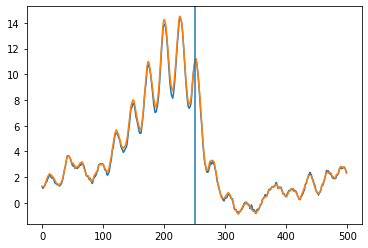

In [15]:
plt.plot(responses_split[20,cluster_id,0,:])
plt.plot(old)
plt.axvline(250)

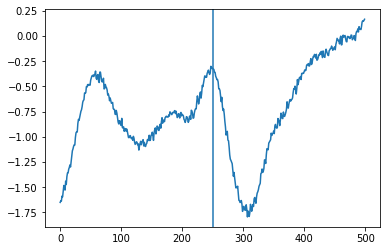

In [167]:
plt.plot(responses_notch[20,cluster_id,0,:]-responses_notch[20,cluster_id,1,:])
plt.axvline(250)

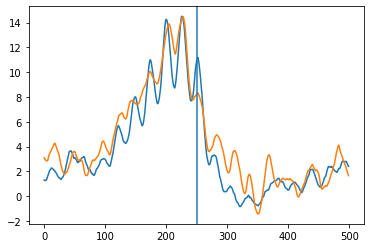

In [154]:
plt.plot(responses_split[20,cluster_id,0,:])
plt.plot(responses_split[20,cluster_id,1,:])
plt.axvline(250)

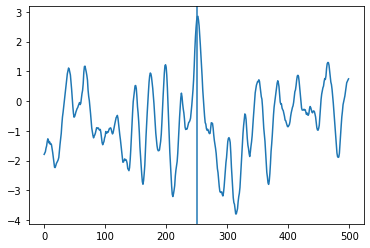

In [153]:
plt.plot(responses_split[20,cluster_id,0,:]-responses_split[20,cluster_id,1,:])
plt.axvline(250)

In [171]:
##################
### Deconvolve ###
##################

all_signals_unfiltered = np.reshape(responses_split[:,:,:,:],(31*2000,4,500))
all_signals = np.reshape(responses_notch,(31*2000,4,500))

all_signals_flipped = all_signals[:,:,::-1]
all_signals_deconv = []
for beh_idx in [0,1,2,3]:
    print(beh_idx)
    # flip filters in time
    temp = all_signals_flipped[:,beh_idx,:]

    # deconvolve
    deconv = np.linalg.lstsq(toe, temp.T)[0]
    deconv_smooth = gaussian_filter1d(deconv,sigma=3,axis=0)

    # Remove edge artifact
    deconv_smooth[:5,:] = deconv_smooth[5,:]
    deconv_smooth[-5:,:] = deconv_smooth[-5,:]

    # Flip back to being backwards in time
    deconv_smooth = deconv_smooth[::-1,:]
    all_signals_deconv.append(deconv_smooth)
all_signals_deconv = np.asarray(all_signals_deconv)
all_signals_deconv = np.swapaxes(all_signals_deconv,0,1)
all_signals_deconv = np.swapaxes(all_signals_deconv,0,2)

0
1
2
3


In [157]:
all_signals_unfiltered.shape

(62000, 4, 500)

In [136]:
all_signals_deconv.shape

(62000, 4, 500)

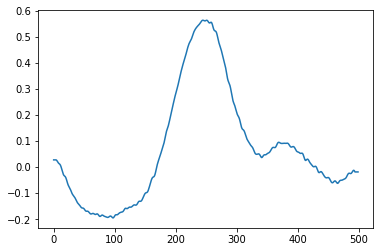

In [139]:
plt.plot(all_signals_deconv[10000,0,:])

In [172]:
######################
### Get peaks, etc ###
######################

all_maxs = np.max(np.abs(all_signals_deconv),axis=-1)
thresholds = np.percentile(all_maxs,60,axis=0)
#thresholds = np.percentile(all_maxs,70,axis=0)


peaks = {}
peaks_ms = {}
peaks_unfiltered = {}
thresholded_filters_ = {}
thresholded_filters_norm = {}
thresholded_filters_norm_unfiltered = {}
to_delete = {}
for beh_idx in [0,1,2,3]:
    print(beh_idx)
    to_delete_ = np.where(all_maxs[:,beh_idx]<thresholds[beh_idx])
    thresholded_filters = np.delete(all_signals_deconv[:,beh_idx,:], to_delete_, axis=0)
    
    # add gaussian smoothing
    thresholded_filters = gaussian_filter1d(thresholded_filters,sigma=2,axis=-1)
    thresholded_filters_[beh_idx] = thresholded_filters
    
    peaks_ = np.argmax(thresholded_filters,axis=-1)
    #idx_sort = np.argsort(peaks)
    maxs = np.max(thresholded_filters,axis=-1)
    thresholded_filters_norm_ = thresholded_filters/maxs[:,np.newaxis]
    
    peaks[beh_idx] = peaks_
    peaks_ms[beh_idx] = (peaks_-250)*20
    thresholded_filters_norm[beh_idx] = thresholded_filters_norm_
    to_delete[beh_idx] = to_delete_
    
    thresholded_filters_unfiltered = np.delete(all_signals_unfiltered[:,beh_idx,:], to_delete_, axis=0)
    maxs = np.max(thresholded_filters_unfiltered,axis=-1)
    thresholded_filters_norm_ = thresholded_filters_unfiltered/maxs[:,np.newaxis]
    thresholded_filters_norm_unfiltered[beh_idx] = thresholded_filters_norm_
    
    peaks_ = np.argmax(thresholded_filters_unfiltered,axis=-1)
    peaks_unfiltered[beh_idx] = peaks_

0
1
2
3


In [158]:
all_signals_deconv.shape

(62000, 4, 500)

In [ ]:
all_signals_deconv

In [161]:
all_maxs = np.max(np.abs(all_signals_deconv[:,:,:]),axis=-1)


In [163]:
thresholded_filters.shape

(24800, 500)

In [ ]:
### get peak of subtraction - new test not sure if valid

all_maxs = np.max(np.abs(all_signals_deconv),axis=-1)
thresholds = np.percentile(all_maxs,60,axis=0)
#thresholds = np.percentile(all_maxs,70,axis=0)


peaks = {}
peaks_ms = {}
peaks_unfiltered = {}
thresholded_filters_ = {}
thresholded_filters_norm = {}
thresholded_filters_norm_unfiltered = {}
to_delete = {}
for beh_idx in [0,1,2,3]:
    print(beh_idx)
    to_delete_ = np.where(all_maxs[:,beh_idx]<thresholds[beh_idx])
    thresholded_filters = np.delete(all_signals_deconv[:,beh_idx,:], to_delete_, axis=0)
    
    # add gaussian smoothing
    thresholded_filters = gaussian_filter1d(thresholded_filters,sigma=2,axis=-1)
    thresholded_filters_[beh_idx] = thresholded_filters
    
    peaks_ = np.argmax(thresholded_filters[:,175:275],axis=-1) + 175
    #idx_sort = np.argsort(peaks)
    maxs = np.max(thresholded_filters,axis=-1)
    thresholded_filters_norm_ = thresholded_filters/maxs[:,np.newaxis]
    
    peaks[beh_idx] = peaks_
    peaks_ms[beh_idx] = (peaks_-250)*20
    thresholded_filters_norm[beh_idx] = thresholded_filters_norm_
    to_delete[beh_idx] = to_delete_
    
    thresholded_filters_unfiltered = np.delete(all_signals_unfiltered[:,beh_idx,:], to_delete_, axis=0)
    maxs = np.max(thresholded_filters_unfiltered,axis=-1)
    thresholded_filters_norm_ = thresholded_filters_unfiltered/maxs[:,np.newaxis]
    thresholded_filters_norm_unfiltered[beh_idx] = thresholded_filters_norm_
    
    peaks_ = np.argmax(thresholded_filters_unfiltered,axis=-1)
    peaks_unfiltered[beh_idx] = peaks_

In [118]:
all_signals_deconv.shape

(62000, 4, 500)

In [120]:
all_filters = {}
for beh_idx in [0,1,2,3]:
    to_plot = np.reshape(all_signals_deconv[:,beh_idx,:], (31,2000,500))
    all_colored_by_betas = []
    for z in range(9,49-9):
        colored_by_betas = np.zeros((256*128,500))
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
            colored_by_betas[cluster_indicies,:] = to_plot[z-9,cluster_num,:]
        colored_by_betas = colored_by_betas.reshape(256,128,500)
        all_colored_by_betas.append(colored_by_betas)
    all_colored_by_betas = np.asarray(all_colored_by_betas)
    all_filters[beh_idx] = all_colored_by_betas

In [140]:
all_filters[0].shape

(31, 256, 128, 500)

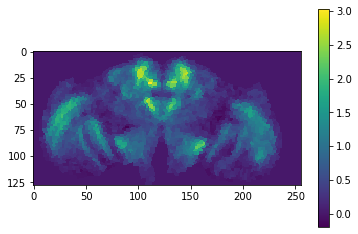

In [135]:
plt.imshow(all_filters[0][15,:,:,250].T)
plt.colorbar()

In [119]:
to_plot.shape

(31, 2000, 500)

In [ ]:
# #behs = ['Vf', 'Vr+', 'Vr-', 'Wlk']
# all_filters = {}
# for beh_idx in [0,1,2,3]:
    
#     add_deleted_voxels = np.zeros((62000,500))
#     to_replace = [i for i in range(62000) if i not in to_delete[beh_idx][0]]
#     add_deleted_voxels[to_replace,:] = thresholded_filters_[beh_idx] #cluster_ids #model.labels_ ### put signal here
#     to_plot = np.reshape(add_deleted_voxels, (31,2000,500))

#     all_colored_by_betas = []
#     for z in range(9,49-9):
#         colored_by_betas = np.zeros((256*128,500))
#         for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
#             cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
#             colored_by_betas[cluster_indicies,:] = to_plot[z-9,cluster_num,:]
#         colored_by_betas = colored_by_betas.reshape(256,128,500)
#         all_colored_by_betas.append(colored_by_betas)
#     all_colored_by_betas = np.asarray(all_colored_by_betas)
#     all_filters[beh_idx] = all_colored_by_betas

In [64]:
peaks[3].shape

(24800,)

In [59]:
thresholded_filters.shape

(24800, 500)

In [60]:
thresholded_filters_unfiltered.shape

(24800, 500)

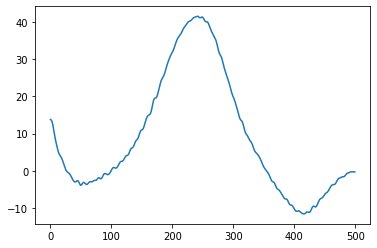

In [117]:
plt.plot(thresholded_filters[1000,:])

In [65]:
thresholded_filters.shape

(24800, 500)

In [76]:
#behs = ['Vf', 'Vr+', 'Vr-', 'Wlk']
all_filters = {}
for beh_idx in [0,1,2,3]:
    
    add_deleted_voxels = np.zeros((62000,500))
    to_replace = [i for i in range(62000) if i not in to_delete[beh_idx][0]]
    add_deleted_voxels[to_replace,:] = thresholded_filters_[beh_idx] #cluster_ids #model.labels_ ### put signal here
    to_plot = np.reshape(add_deleted_voxels, (31,2000,500))

    all_colored_by_betas = []
    for z in range(9,49-9):
        colored_by_betas = np.zeros((256*128,500))
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
            colored_by_betas[cluster_indicies,:] = to_plot[z-9,cluster_num,:]
        colored_by_betas = colored_by_betas.reshape(256,128,500)
        all_colored_by_betas.append(colored_by_betas)
    all_colored_by_betas = np.asarray(all_colored_by_betas)
    all_filters[beh_idx] = all_colored_by_betas

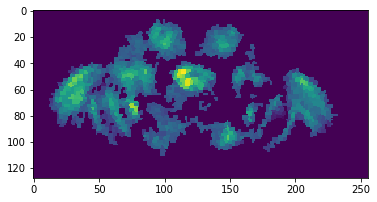

In [87]:
plt.imshow(all_filters[1][10,:,:,250].T)

In [141]:
all_filters[0].shape

(31, 256, 128, 500)

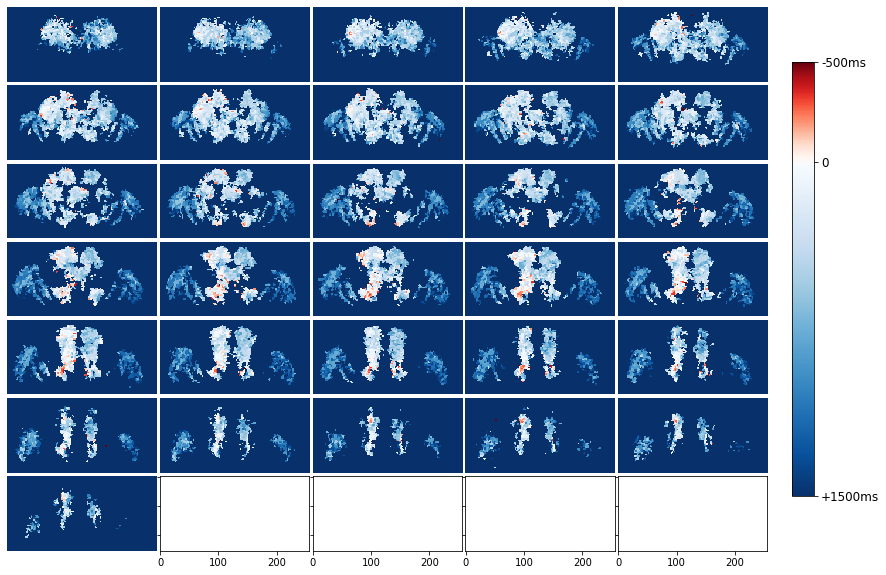

In [175]:
for beh_idx in [1]:
    #behs = ['Vf', 'Vr+', 'Vr-', 'Wlk']

    add_deleted_voxels = np.zeros(62000)
    to_replace = [i for i in range(62000) if i not in to_delete[beh_idx][0]]
    add_deleted_voxels[to_replace] = peaks[beh_idx] #cluster_ids #model.labels_ ### put signal here
    to_plot = np.reshape(add_deleted_voxels, (31,2000))

    all_colored_by_betas = []
    for z in range(9,49-9):
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = to_plot[z-9,cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,128)
        all_colored_by_betas.append(colored_by_betas)
    all_colored_by_betas = np.asarray(all_colored_by_betas)
    # to_plot = np.max(all_colored_by_betas, axis=0)
    # plt.imshow(to_plot[:,:].T)
    all_colored_by_betas[all_colored_by_betas==0] = 0 #np.nan #<--------------------

    start = 265 ###
    end = 200 ######## most used
    middle = 250 ###
    
#     start = 275
#     end = 175
#     middle = 250
    
#     start = 265
#     end = 235
#     middle = 250
    
#     start = 235
#     end = 190
    #middle = 250

    # sample the colormaps that you want to use. Use 128 from each so we get 256
    # colors in total
    colors1 = plt.cm.Blues_r(np.linspace(0., 1, middle-end))
    colors2 = plt.cm.Reds(np.linspace(0, 1, start-middle))

    # combine them and build a new colormap
    colors = np.vstack((colors1, colors2))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

    mymap.set_bad(color='grey')

    fig = plt.figure(figsize=(20,10))
    grid = ImageGrid(fig, 111, nrows_ncols=(7, 5), axes_pad=.05)
    for i in range(31):
        cax = grid[i].imshow(all_colored_by_betas[i,:,:].T,cmap=mymap,vmin=end,vmax=start);
        #cax = grid[i].imshow(all_colored_by_betas[i,:,:].T,cmap='jet',vmin=end,vmax=start);
        grid[i].axis('off')

    cbar = fig.colorbar(cax, ticks=[start, middle, end],shrink=.8, anchor=(.1,.5))
    cbar.ax.set_yticklabels(['-500ms', '0', '+1500ms'], fontsize=12)

#     cbar = fig.colorbar(cax, ticks=[start, end],shrink=.8, anchor=(.1,.5))
#     cbar.ax.set_yticklabels(['+300ms', '+1000ms'], fontsize=12)

    #plt.suptitle(f'{behs[beh_idx]}',y=.93)

    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fname = os.path.join(save_path, f'{timestr}')
    #plt.savefig(fname,dpi=300,bbox_inches='tight')

In [142]:
all_filters[0].shape

(31, 256, 128, 500)

In [143]:
all_colored_by_betas_full_ = {}
for beh_idx in [0,1,2,3]:
    pad = np.zeros((9,256,128,500))
    all_colored_by_betas_full = np.concatenate((pad,all_filters[beh_idx],pad))
    all_colored_by_betas_full = np.moveaxis(all_colored_by_betas_full,0,2)
    all_colored_by_betas_full_[beh_idx] = all_colored_by_betas_full

In [144]:
all_colored_by_betas_full_[0].shape

(256, 128, 49, 500)

In [145]:
maps_voxel_res_ = {}
for beh_idx in [0,1,2,3]:
    print(beh_idx)
    moving = ants.from_numpy(all_colored_by_betas_full_[beh_idx][:,:,::-1,:])
    moving.set_spacing((2.6076, 2.6154, 5.3125, 1)) ### matching this to the slightly off luke mean
    out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')
    maps_voxel_res = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0], imagetype=3, interpolator='nearestNeighbor')
    maps_voxel_res_[beh_idx] = maps_voxel_res

0
1
2
3


In [93]:
maps_voxel_res_[0].shape

(241, 112, 36, 500)

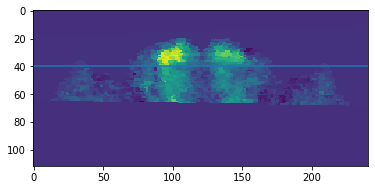

In [146]:
plt.imshow(maps_voxel_res_[1][:,:,10,250].T)
plt.axhline(40)

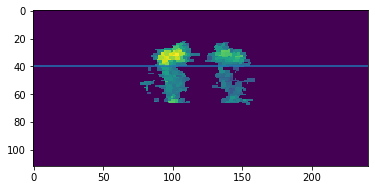

In [109]:
plt.imshow(maps_voxel_res_[1][:,:,10,250].T)
plt.axhline(40)

In [147]:
dir_ = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/"
save_dir = os.path.join(dir_, "20220919_temporal_filters_in_FDA")
for beh_idx in [0,1,2,3]:
    save_file = os.path.join(save_dir, F'filters_{beh_idx}')
    np.save(save_file, maps_voxel_res_[beh_idx].numpy())

In [115]:
os.listdir(save_dir)

['filters_2.npy', 'filters_3.npy', 'filters_1.npy', 'filters_0.npy']

In [103]:
def load_FDA():
    FDA_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20220301_luke_2_jfrc_affine.nii'
    FDA = np.asarray(nib.load(FDA_file).get_fdata().squeeze(), dtype='float32')
    FDA = ants.from_numpy(FDA)
    FDA.set_spacing((.38,.38,.38))
    FDA_lowres = ants.resample_image(FDA,(2.6,2.6,5),use_voxels=False)
    return FDA, FDA_lowres

FDA, FDA_lowres = load_FDA()

# hemibrain bounding box
start = {'x': 46, 'y': 5, 'z': 5}
stop = {'x': 147, 'y': 89, 'z': 34}

FDA_crop = FDA_lowres[start['x']:stop['x'],
                     start['y']:stop['y'],
                     start['z']:stop['z']]

In [104]:
FDA_lowres.shape

(241, 112, 36)

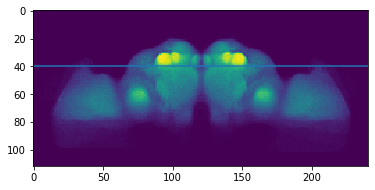

In [110]:
plt.imshow(FDA_lowres[:,:,10].T)
plt.axhline(40)

In [41]:
fixed_lowres.shape

(241, 112, 36)

In [47]:
# hemibrain bounding box
start = {'x': 46, 'y': 5, 'z': 5}
stop = {'x': 147, 'y': 89, 'z': 34}

filters_cropped = maps_voxel_res[start['x']:stop['x'],
                                  start['y']:stop['y'],
                                  start['z']:stop['z']]
filters_cropped.shape

(101, 84, 29)

In [45]:
maps_voxel_res

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (241, 112, 36)
	 Spacing    : (2.6, 2.6, 5.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

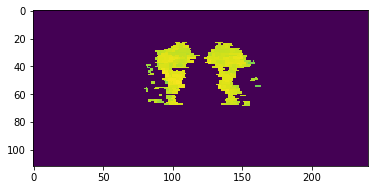

In [44]:
plt.imshow(maps_voxel_res[:,:,10].T)

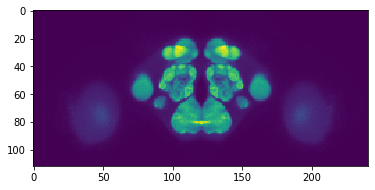

In [43]:
plt.imshow(fixed_lowres[:,:,10].T)

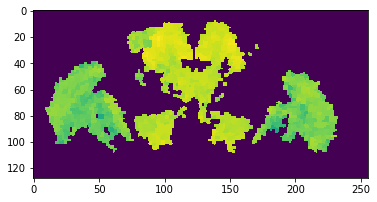

In [21]:
plt.imshow(all_colored_by_betas[15,:,:].T)

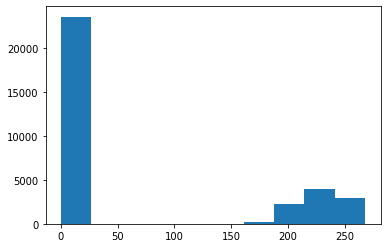

In [23]:
plt.hist(all_colored_by_betas[15,:,:].flatten());

In [18]:
all_colored_by_betas.shape

(31, 256, 128)

In [24]:
49-31

18

In [ ]:
np.zeros()

In [20]:
all_colored_by_betas[20,:,:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
fixed_lowres

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (314, 146, 91)
	 Spacing    : (2.0, 2.0, 2.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [36]:
############################
### load behavior scores ###
############################
connectome_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220624_supervoxels_in_FDA'
unique_crop = np.load(os.path.join(connectome_dir, 'unique_glm_in_hemibrain.npy'))

behavior = []
for beh in [0,1,2]:
    unique_crop_thresh = unique_crop[...,beh].copy()
    unique_crop_thresh[unique_crop[...,beh]>=.010] = 1
    unique_crop_thresh[unique_crop[...,beh]<.010] = np.nan
    behavior.append(unique_crop_thresh==1)

In [37]:
behavior[0].shape

(101, 84, 29)